In [1]:
%cd ..
%matplotlib inline

/home/elias/work/generative-scattering-networks



Regularized inverse of a scattering transform on MNIST
======================================================

Description:
This example trains a convolutional network to invert the scattering transform at scale 2 of MNIST digits.
After only two epochs, it produces a network that transforms a linear interpolation in the scattering space into a
nonlinear interpolation in the image space.

Remarks:
The model after two epochs and the path (which consists of a sequence of images) are stored in the cache directory.
The two epochs take roughly 5 minutes in a Quadro M6000.

Reference:
https://arxiv.org/abs/1805.06621



In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

from kymatio import Scattering2D as Scattering
from kymatio.caching import get_cache_dir
from kymatio.datasets import get_dataset_dir

In [3]:
class Generator(nn.Module):
    def __init__(self, num_input_channels, num_hidden_channels, num_output_channels=1, filter_size=3):
        super(Generator, self).__init__()
        self.num_input_channels = num_input_channels
        self.num_hidden_channels = num_hidden_channels
        self.num_output_channels = num_output_channels
        self.filter_size = filter_size
        self.build()

    def build(self):
        padding = (self.filter_size - 1) // 2

        self.main = nn.Sequential(
            nn.ReflectionPad2d(padding),
            nn.Conv2d(self.num_input_channels, self.num_hidden_channels, self.filter_size, bias=False),
            nn.BatchNorm2d(self.num_hidden_channels, eps=0.001, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),

            nn.ReflectionPad2d(padding),
            nn.Conv2d(self.num_hidden_channels, self.num_hidden_channels, self.filter_size, bias=False),
            nn.BatchNorm2d(self.num_hidden_channels, eps=0.001, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),

            nn.ReflectionPad2d(padding),
            nn.Conv2d(self.num_hidden_channels, self.num_output_channels, self.filter_size, bias=False),
            nn.BatchNorm2d(self.num_output_channels, eps=0.001, momentum=0.9),
            nn.Tanh()
        )

    def forward(self, input_tensor):
        return self.main(input_tensor)

In [8]:
def main(num_epochs=2, load_model=False, dir_save_images="tmp/interpolation_images"):
    dir_to_save = get_cache_dir('reg_inverse_example')

    transforms_to_apply = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Pixel values should be in [-1,1]
    ])

    mnist_dir = get_dataset_dir("MNIST", create=True)
    dataset = datasets.MNIST(mnist_dir, train=True, download=True, transform=transforms_to_apply)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True, pin_memory=True)

    fixed_dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
    fixed_batch = next(iter(fixed_dataloader))
    fixed_batch = fixed_batch[0].float()  # .cuda()

    scattering = Scattering(J=2, shape=(28, 28))
#     scattering.cuda()

    scattering_fixed_batch = scattering(fixed_batch).squeeze(1)
    num_input_channels = scattering_fixed_batch.shape[1]
    num_hidden_channels = num_input_channels

    generator = Generator(num_input_channels, num_hidden_channels)
#     generator.cuda()
    generator.train()

    # Either train the network or load a trained model
    ##################################################
    if load_model:
        filename_model = os.path.join(dir_to_save, 'model.pth')
        generator.load_state_dict(torch.load(filename_model))
    else:
        criterion = torch.nn.L1Loss()
        optimizer = optim.Adam(generator.parameters())

        for idx_epoch in range(num_epochs):
            print('Training epoch {}'.format(idx_epoch))
            for _, current_batch in enumerate(tqdm(dataloader)):
                generator.zero_grad()
                batch_images = Variable(current_batch[0]).float()  # .cuda()
                batch_scattering = scattering(batch_images).squeeze(1)
                batch_inverse_scattering = generator(batch_scattering)
                loss = criterion(batch_inverse_scattering, batch_images)
                loss.backward()
                optimizer.step()

        print('Saving results in {}'.format(dir_to_save))

        torch.save(generator.state_dict(), os.path.join(dir_to_save, 'model.pth'))

    generator.eval()

    # We create the batch containing the linear interpolation points in the scattering space
    ########################################################################################
    z0 = scattering_fixed_batch.cpu().numpy()[[0]]
    z1 = scattering_fixed_batch.cpu().numpy()[[1]]
    batch_z = np.copy(z0)
    num_samples = 32
    interval = np.linspace(0, 1, num_samples)
    for t in interval:
        if t > 0:
            zt = (1 - t) * z0 + t * z1
            batch_z = np.vstack((batch_z, zt))

    z = torch.from_numpy(batch_z).float()  # .cuda()
    path = generator(z).data.cpu().numpy().squeeze(1)
    path = (path + 1) / 2  # The pixels are now in [0, 1]

    # We show and store the nonlinear interpolation in the image space
    ##################################################################
    dir_path = os.path.join(dir_to_save, dir_save_images)

    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    for idx_image in range(num_samples):
        current_image = np.uint8(path[idx_image] * 255.0)
        filename = os.path.join(dir_path, '{}.png'.format(idx_image))
        Image.fromarray(current_image).save(filename)
        plt.imshow(current_image, cmap='gray')
        plt.axis('off')
        plt.pause(0.1)
        plt.draw()

  0%|          | 0/469 [00:00<?, ?it/s]

Training epoch 0


  0%|          | 0/469 [00:00<?, ?it/s]

Training epoch 1


100%|██████████| 469/469 [09:49<00:00,  1.26s/it]

Saving results in /home/elias/kymatio_cache/reg_inverse_example


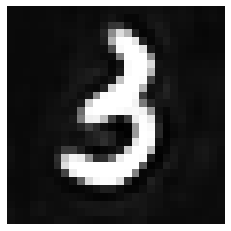

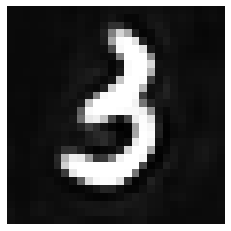

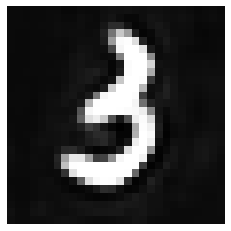

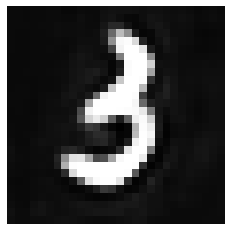

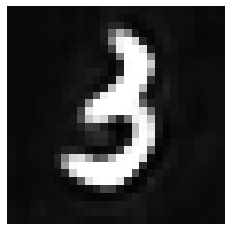

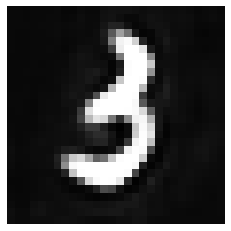

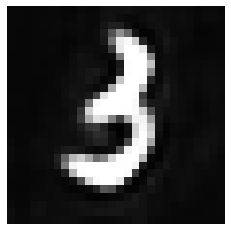

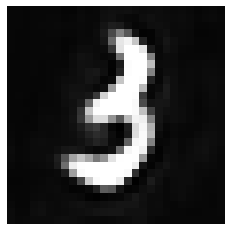

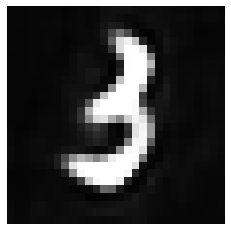

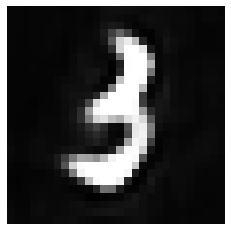

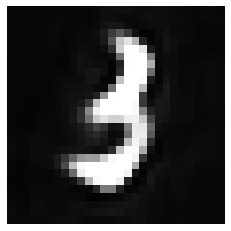

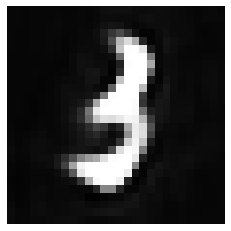

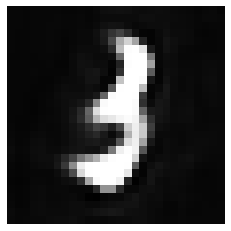

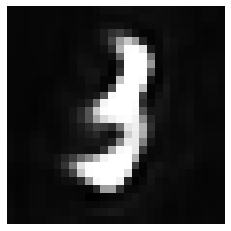

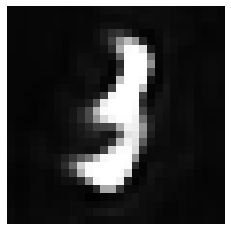

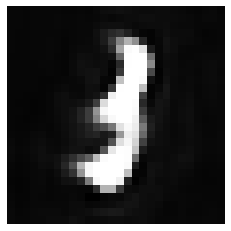

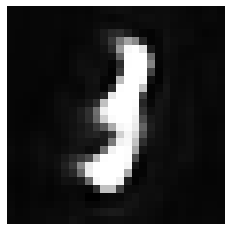

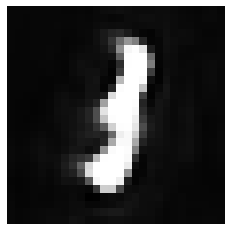

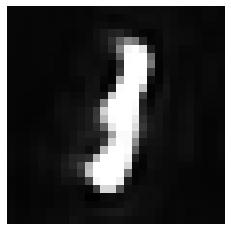

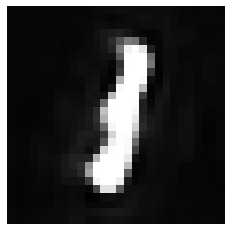

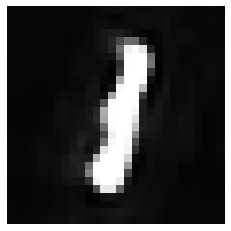

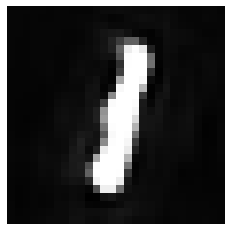

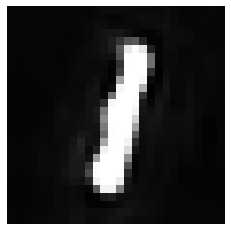

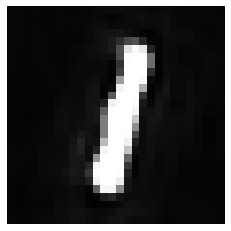

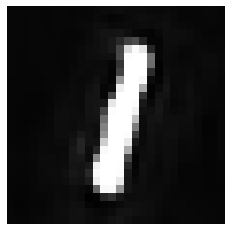

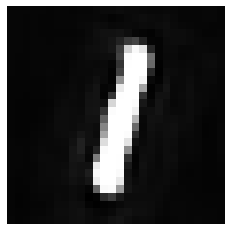

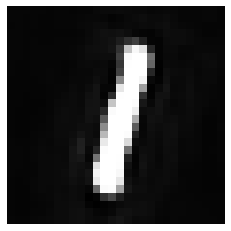

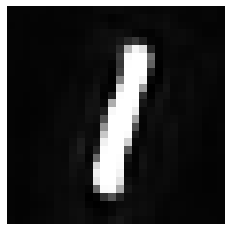

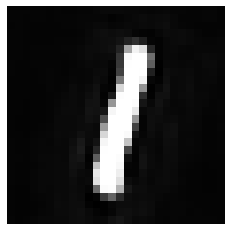

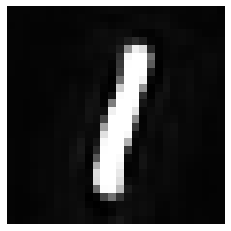

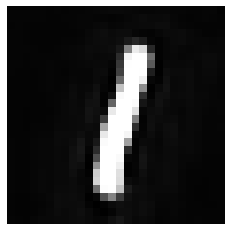

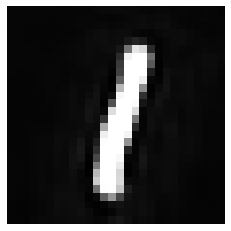

<Figure size 432x288 with 0 Axes>

In [9]:
main()